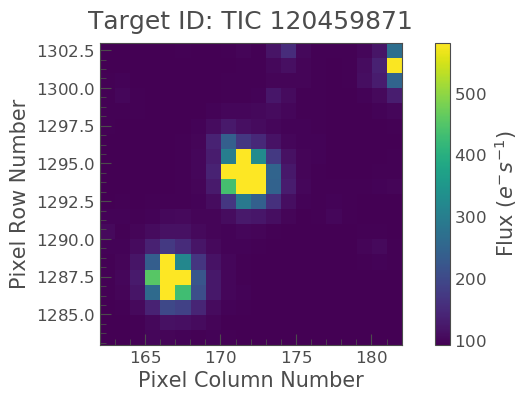

In [9]:
import lightkurve as lk
from lightkurve import search_targetpixelfile
#import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import astropy.units as u
import numpy as np
from scipy.optimize import leastsq
import pylab as plt

tpf = lk.search_tesscut('TIC 120459871').download(cutout_size=20)


#searchresult=tpf.SearchResult
tpf.plot()

In [10]:
tpf

TessTargetPixelFile(TICID: TIC 120459871)

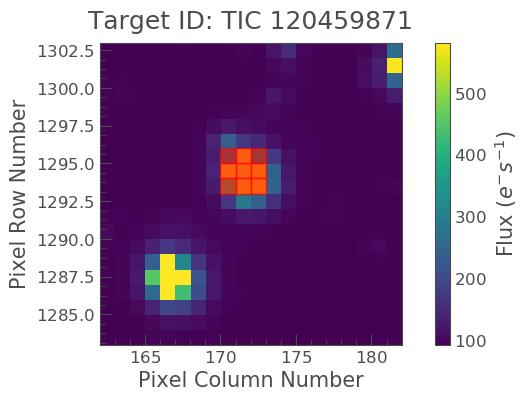

In [11]:
%matplotlib inline
import numpy as np
aper = np.zeros(tpf.shape[1:], dtype=np.int)
aper[10:13, 8:11] = 1
tpf.plot(aperture_mask=aper, mask_color='red');

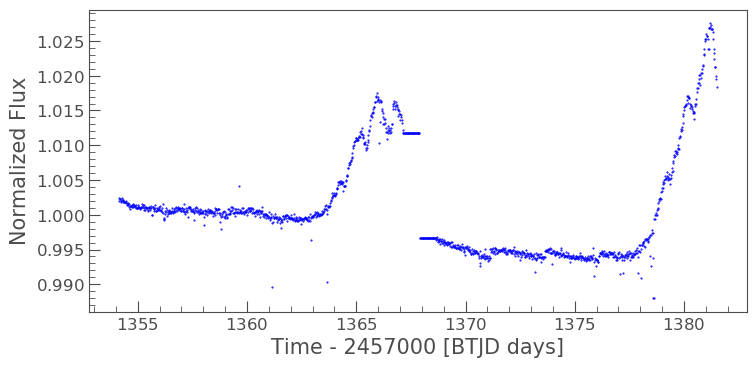

In [16]:
import matplotlib.pyplot as plt

user_lc = tpf.to_lightcurve(aperture_mask=aper.astype(bool))
# Clean the light curve
user_lc = user_lc.remove_nans().remove_outliers().fill_gaps()
user_lc.plot(marker='.',linestyle='None',color='blue')
#plt.ylim(0.9,1.1)

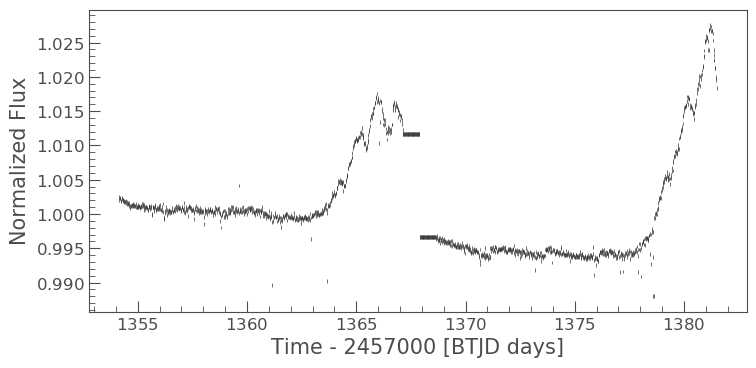

In [17]:
user_lc.errorbar();

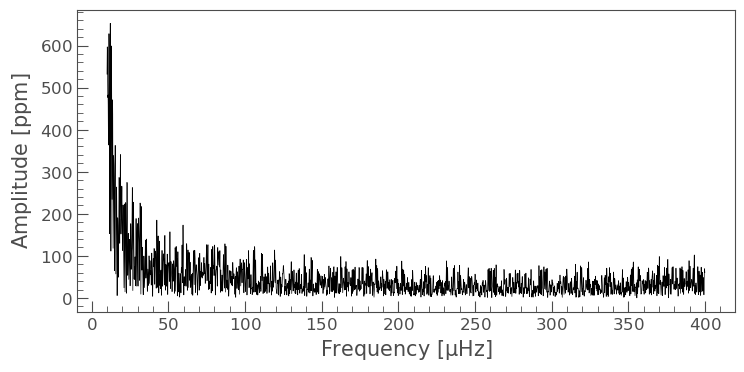

In [18]:
p = user_lc.to_periodogram(freq_unit=u.microHertz, maximum_frequency=400, minimum_frequency=10)
ax = p.plot(c='k');

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 7.32289769 d>

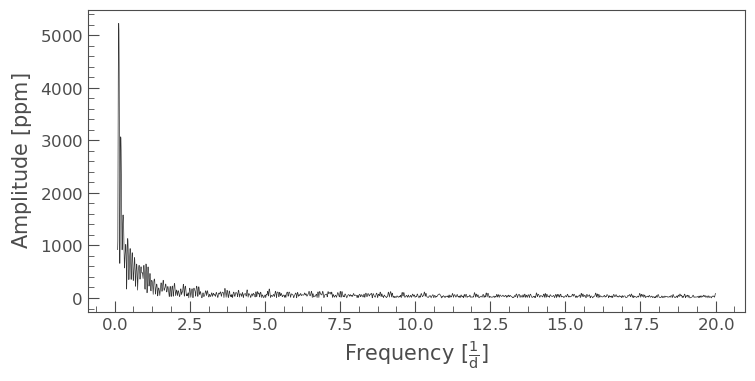

In [19]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(user_lc, minimum_period=0.05, maximum_period =10)
periodogram.plot()
periodogram.period_at_max_power


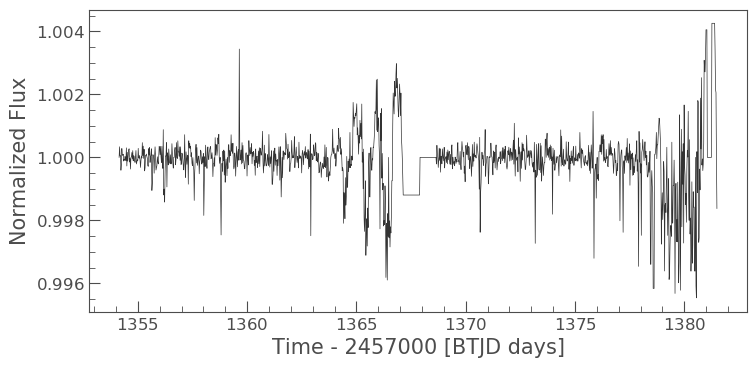

In [32]:
lc = tpf.to_lightcurve(aperture_mask=aper.astype(bool)).normalize().remove_nans().remove_outliers()
clc = lc.to_corrector("sff").correct().remove_outliers().fill_gaps()
clc.plot()

/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 1.0823107 d>

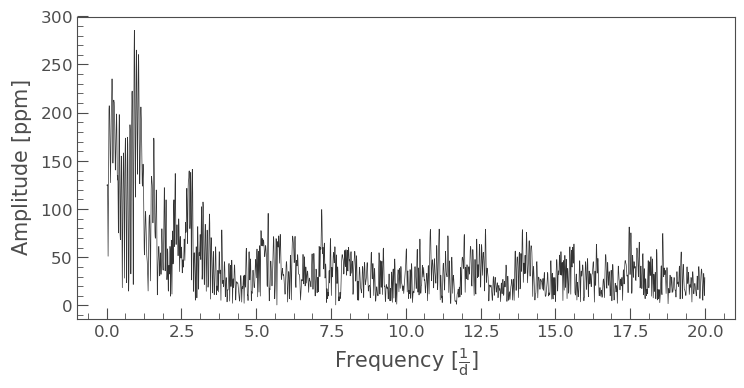

In [33]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(clc, minimum_period=0.05, maximum_period =100)
periodogram.plot()
periodogram.period_at_max_power

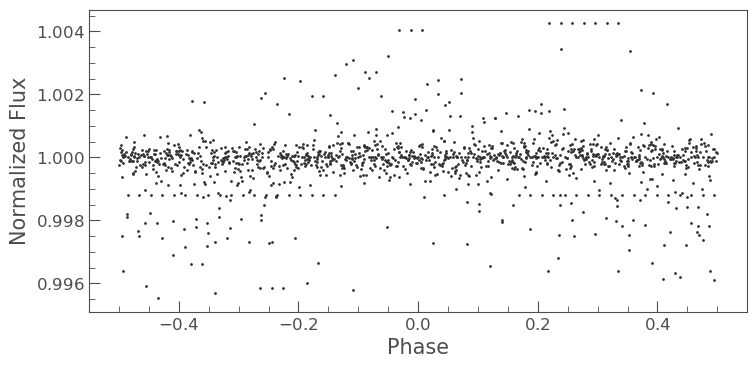

In [34]:
folded_lightcurve = clc.fold(periodogram.period_at_max_power.value)
folded_lightcurve.plot(marker='o',linestyle='none')

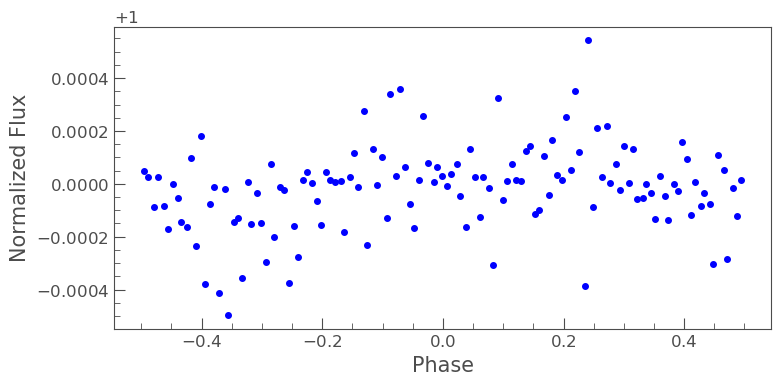

In [36]:
bin_folded_lc = folded_lightcurve.bin(10,method='median')
bin_folded_lc.plot(marker='o',linestyle='None',markersize=4,color='blue',title='K2')

In [37]:
corrector=lk.SFFCorrector(lc)
new_lc = corrector.correct(lc.centroid_col,lc.centroid_row)

1.0823106988682063 d


/anaconda3/lib/python3.6/site-packages/lightkurve/periodogram.py:693: LightkurveWarning: As of Lightkurve v1.0.0 (Apr 2019), the default behavior of Lomb Scargle periodograms changed to use normalization='amplitude' and oversample_factor=5 (the previous defaults were normalization='psd' and oversample_factor=1). You can suppress this warning using `warnings.filterwarnings('ignore', category=lk.LightkurveWarning)`.
  LightkurveWarning)


<Quantity 0.9239491 1 / d>

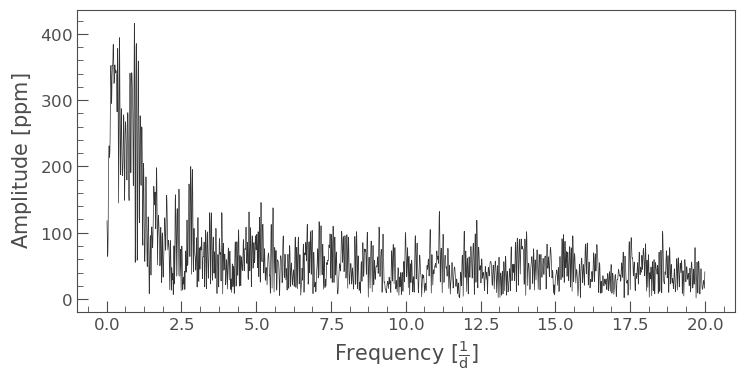

In [38]:
periodogram=lk.periodogram.LombScarglePeriodogram.from_lightcurve(new_lc, minimum_period=0.05, maximum_period =100)
periodogram.plot()
print(periodogram.period_at_max_power)
periodogram.frequency_at_max_power


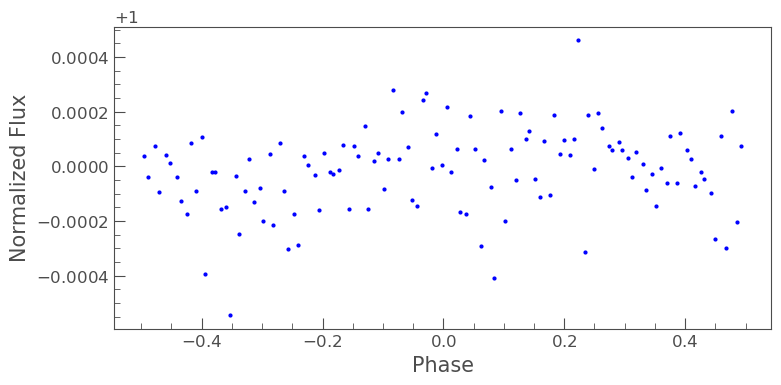

In [40]:
folded_lightcurve = new_lc.fold(periodogram.period_at_max_power.value)

bin_folded_lc = folded_lightcurve.bin(10,method='median')
bin_folded_lc.plot(marker='.',linestyle='None',markersize=4,color='blue',title='K2')

In [41]:
len(bin_folded_lc.flux)

122

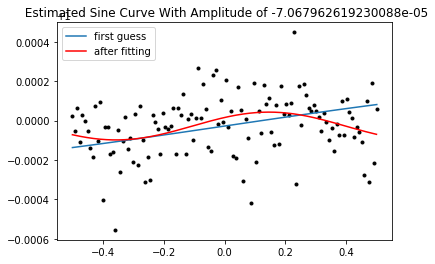

-6.251358048524843


In [42]:


N = len(bin_folded_lc.flux) # number of data points
t = np.linspace(-0.5, 0.5, N)
#f = 9.7532921 # Optional!! Advised not to use
#data = 3.0*np.sin(f*t+0.001) + 0.5 + np.random.randn(N) # create artificial data with noise

guess_mean = np.mean(bin_folded_lc.flux)
guess_std = 3*np.std(bin_folded_lc.flux)/(2**0.5)/(2**0.5)
guess_phase = 0
guess_freq = 1
guess_amp = 1

# we'll use this to plot our first estimate. This might already be good enough for you
data_first_guess = guess_std*np.sin(t+guess_phase) + guess_mean

# Define the function to optimize, in this case, we want to minimize the difference
# between the actual data and our "guessed" parameters
optimize_func = lambda x: x[0]*np.sin(x[1]*t+x[2]) + x[3] - bin_folded_lc.flux
est_amp, est_freq, est_phase, est_mean = leastsq(optimize_func, [guess_amp, guess_freq, guess_phase, guess_mean])[0]

# recreate the fitted curve using the optimized parameters
data_fit = est_amp*np.sin(est_freq*t+est_phase) + est_mean

# recreate the fitted curve using the optimized parameters

fine_t = np.arange(-0.5,0.5,0.001)
data_fit=est_amp*np.sin(est_freq*fine_t+est_phase)+est_mean

plt.plot(t, bin_folded_lc.flux, marker='.', linestyle='none', color='black')
plt.plot(t, data_first_guess, label='first guess')
plt.plot(fine_t, data_fit, label='after fitting', color='red')
#plt.xlim(-0.5,0.5)
plt.legend()
plt.title(' Estimated Sine Curve With Amplitude of '+str(est_amp))
plt.show()
print(est_freq)

